In [70]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import re

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [71]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        text = text.lower()
        text = re.sub(r'([.,!?"\'-])', r' \1 ', text)
        return text.split()

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [72]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):  # Set to False
        super(EncoderCNN, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # First freeze ALL layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Then unfreeze only layer4 and fc
        for name, param in self.resnet.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
        
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):        
        embeddings = self.dropout(self.embedding(captions[:, :-1]))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [73]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [74]:
print("Rebuilding Vocabulary...")
captions_file = "caption_data/captions.txt"
df = pd.read_csv(captions_file)
captions = df["caption"].tolist()

vocab = Vocabulary(freq_threshold=5) 
vocab.build_vocabulary(captions)

print(f"Vocabulary Size: {len(vocab)}")

Rebuilding Vocabulary...
Vocabulary Size: 2994


In [75]:
# Hyperparameters (Must match training)
embed_size = 256
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1

# Initialize Model
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

# Load Weights
model_path = "best_model.pth"
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print("Model loaded successfully.")
else:
    print(f"Error: {model_path} not found.")

Model loaded successfully.


C:\Users\ASUS_ZEPHYRUS\AppData\Local\Temp\ipykernel_2516\4128858856.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=dev

In [76]:
def generate_caption(model, image_path, transform, vocab, device, max_length=50):
    """
    Generate caption for an image using the trained model.
    
    Args:
        model: Trained CNNtoRNN model
        image_path: Path to image file
        transform: Image transformation pipeline
        vocab: Vocabulary object
        device: torch device (cuda/cpu)
        max_length: Maximum caption length
    
    Returns:
        Generated caption as string
    """
    model.eval()
    result_caption = []

    with torch.no_grad():
        # Load and encode image
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        features = model.encoder(image)
        
        # Start with <SOS> token
        states = None
        inputs = torch.tensor([vocab.stoi["<SOS>"]]).to(device)
        
        for i in range(max_length):
            # Embed the input
            embeddings = model.decoder.embedding(inputs).unsqueeze(1)
            
            # For first step, concatenate image features
            if i == 0:
                embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
            
            # LSTM forward pass
            hiddens, states = model.decoder.lstm(embeddings, states)
            outputs = model.decoder.linear(hiddens[:, -1, :])
            predicted = outputs.argmax(1)
            
            predicted_idx = predicted.item()
            word = vocab.itos[predicted_idx]
            
            # Stop if we hit end of sequence
            if word == "<EOS>":
                break
            
            # Don't add special tokens to caption
            if word not in ["<SOS>", "<PAD>"]:
                result_caption.append(word)
            
            # Use predicted word as next input
            inputs = predicted
    
    return " ".join(result_caption)

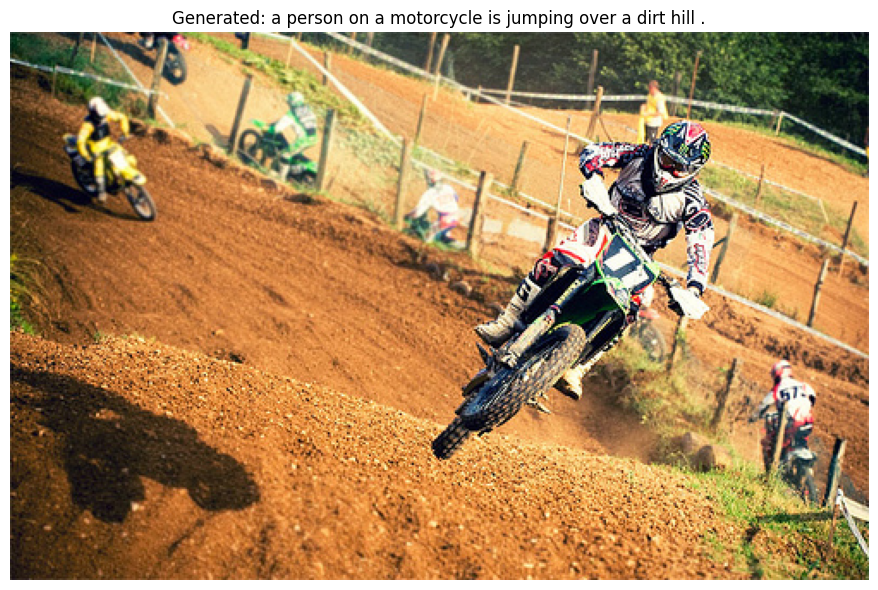

Caption: a person on a motorcycle is jumping over a dirt hill .


In [77]:
test_image_path = "caption_data/images/3697675767_97796334e4.jpg" 

try:
    # Generate Caption
    caption = generate_caption(model, test_image_path, transform, vocab, device)
    
    # Display Image and Caption
    img = Image.open(test_image_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Generated: {caption}", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    print(f"Caption: {caption}")

except FileNotFoundError:
    print(f"File not found: {test_image_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Testing on 5 random images...



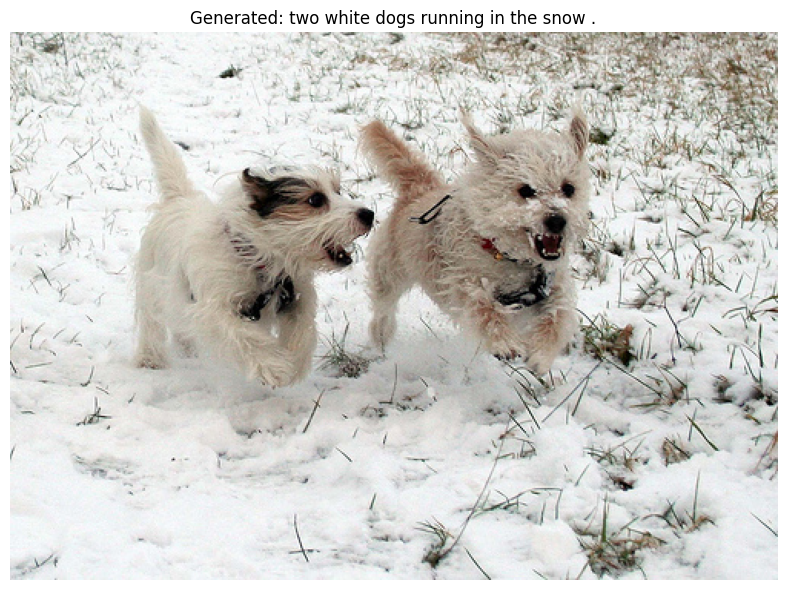

Image: 268704620_8a8cef4cb3.jpg
Caption: two white dogs running in the snow .

--------------------------------------------------------------------------------


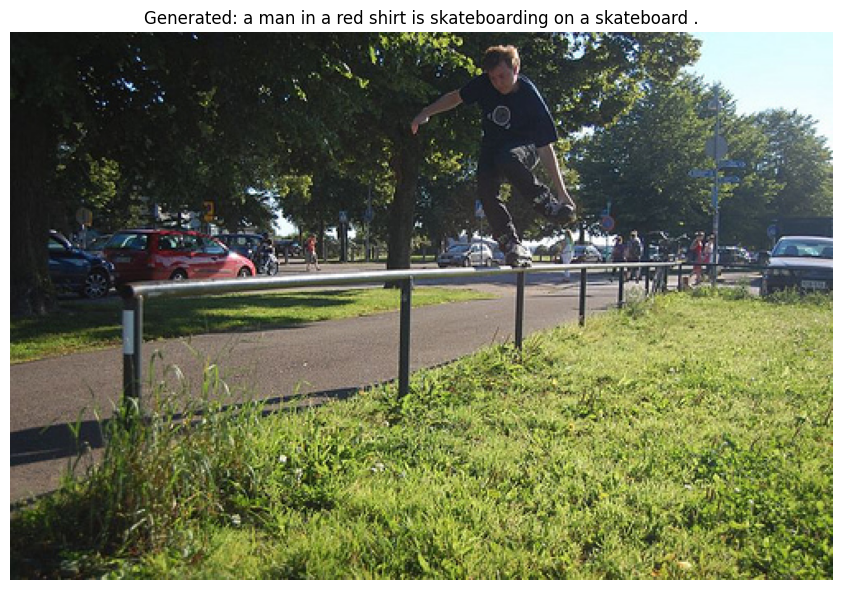

Image: 2696636252_91ef1491ea.jpg
Caption: a man in a red shirt is skateboarding on a skateboard .

--------------------------------------------------------------------------------


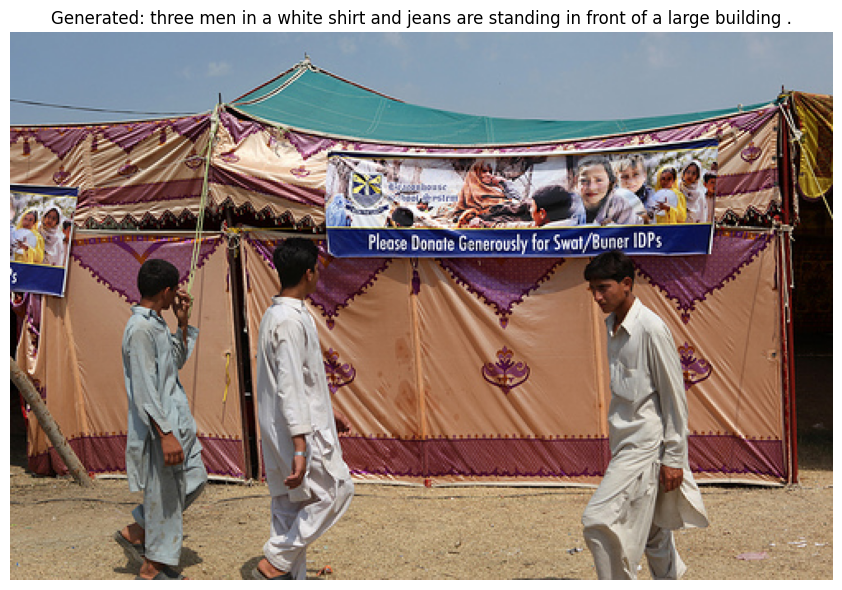

Image: 3553374585_25b1bd6970.jpg
Caption: three men in a white shirt and jeans are standing in front of a large building .

--------------------------------------------------------------------------------


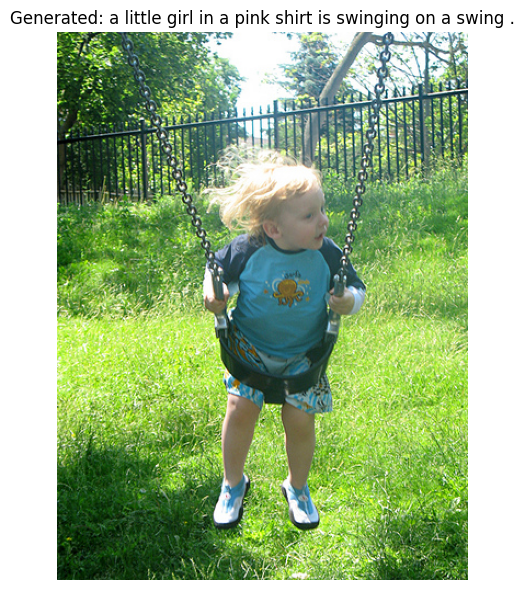

Image: 2629334536_11f2d49e05.jpg
Caption: a little girl in a pink shirt is swinging on a swing .

--------------------------------------------------------------------------------


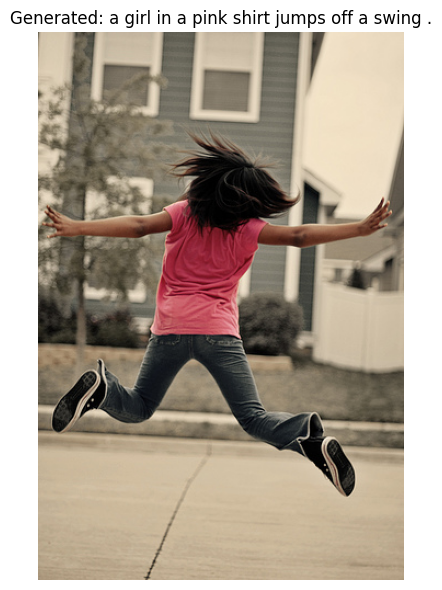

Image: 3477681171_b1bb8b211d.jpg
Caption: a girl in a pink shirt jumps off a swing .

--------------------------------------------------------------------------------


In [ ]:
# Get list of image files
image_dir = "caption_data/images"
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

num_to_test = 5

print(f"Testing on {num_to_test} random images...\n")

import random
random.shuffle(image_files)

for img_file in image_files[:num_to_test]:
    img_path = os.path.join(image_dir, img_file)
    
    try:
        caption = generate_caption(model, img_path, transform, vocab, device)
        
        img = Image.open(img_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.title(f"Generated: {caption}", fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        
        print(f"Image: {img_file}")
        print(f"Caption: {caption}\n")
        print("-" * 80)
        
    except Exception as e:
        print(f"Error with {img_file}: {e}\n")

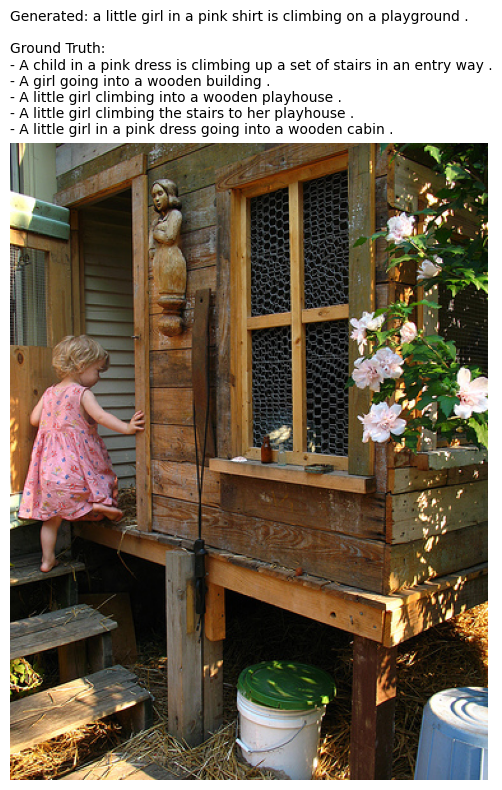

Image: 1000268201_693b08cb0e.jpg
Generated: a little girl in a pink shirt is climbing on a playground .

Ground Truth:
  - A child in a pink dress is climbing up a set of stairs in an entry way .
  - A girl going into a wooden building .
  - A little girl climbing into a wooden playhouse .
  - A little girl climbing the stairs to her playhouse .
  - A little girl in a pink dress going into a wooden cabin .




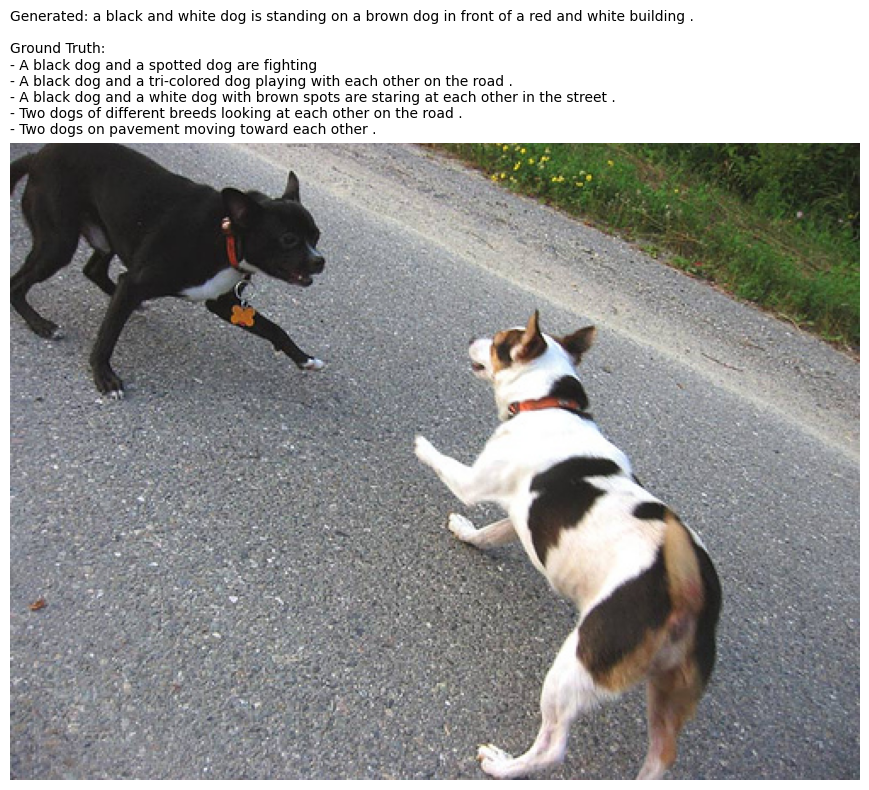

Image: 1001773457_577c3a7d70.jpg
Generated: a black and white dog is standing on a brown dog in front of a red and white building .

Ground Truth:
  - A black dog and a spotted dog are fighting
  - A black dog and a tri-colored dog playing with each other on the road .
  - A black dog and a white dog with brown spots are staring at each other in the street .
  - Two dogs of different breeds looking at each other on the road .
  - Two dogs on pavement moving toward each other .




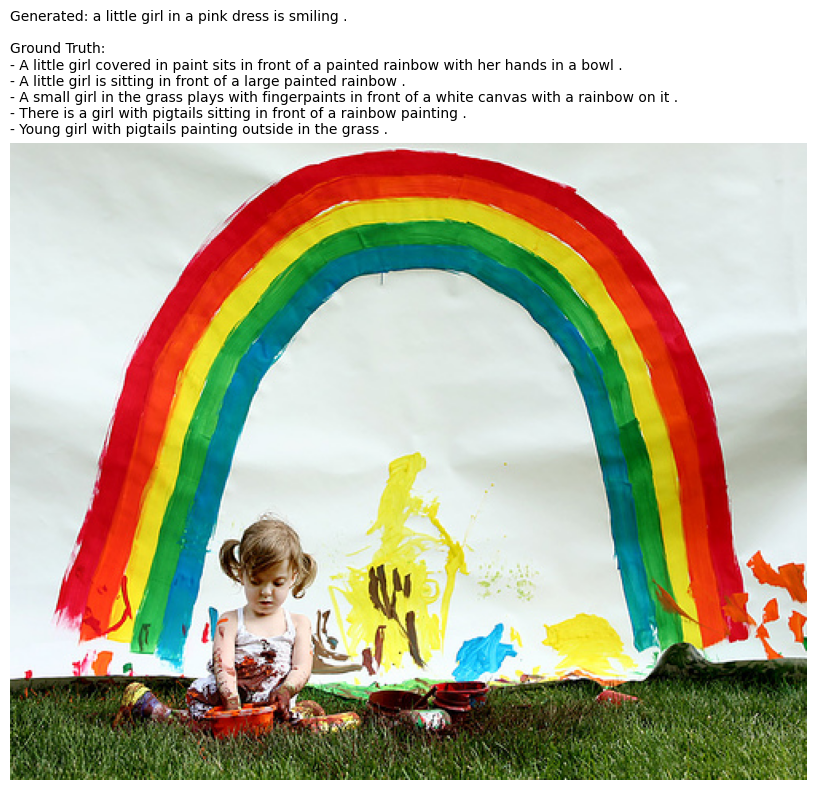

Image: 1002674143_1b742ab4b8.jpg
Generated: a little girl in a pink dress is smiling .

Ground Truth:
  - A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
  - A little girl is sitting in front of a large painted rainbow .
  - A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
  - There is a girl with pigtails sitting in front of a rainbow painting .
  - Young girl with pigtails painting outside in the grass .




In [79]:
# Compare generated captions with actual captions from dataset
def compare_captions(model, image_name, df, transform, vocab, device):
    """Compare generated caption with ground truth captions"""
    # Get actual captions for this image
    actual_captions = df[df['image'] == image_name]['caption'].tolist()
    
    # Generate caption
    img_path = os.path.join("caption_data/images", image_name)
    generated_caption = generate_caption(model, img_path, transform, vocab, device)
    
    # Display
    img = Image.open(img_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    
    caption_text = f"Generated: {generated_caption}\n\n"
    caption_text += "Ground Truth:\n" + "\n".join([f"- {cap}" for cap in actual_captions])
    
    plt.title(caption_text, fontsize=10, loc='left')
    plt.tight_layout()
    plt.show()
    
    print(f"Image: {image_name}")
    print(f"Generated: {generated_caption}")
    print("\nGround Truth:")
    for cap in actual_captions:
        print(f"  - {cap}")
    print("\n" + "="*80 + "\n")

# Test comparison on a few images
sample_images = df['image'].unique()[:3]  # Get first 3 unique images

for img_name in sample_images:
    compare_captions(model, img_name, df, transform, vocab, device)